# CT4101 Assignment 1: Logistic Regression Analysis

This notebook demonstrates Logistic Regression analysis on the wildfire prediction dataset with hyperparameter tuning.

## Dataset Information
- **Training set**: `wildfires_training.csv`
- **Test set**: `wildfires_test.csv`
- **Target variable**: `fire` (yes/no)
- **Features**: Multiple environmental variables

## Key Features of Logistic Regression
- **Linear classifier**: Uses linear decision boundaries
- **Probabilistic output**: Provides probability estimates for predictions
- **Regularization**: L2 regularization to prevent overfitting
- **Feature scaling required**: StandardScaler needed for optimal performance

## Assignment Requirements
- **Hyperparameter tuning**: Testing different penalty types and C values
- **Performance comparison**: Default settings vs best tuned model


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import helper functions from the main script
from ct4101_assignment import load_and_prepare_data, RANDOM_STATE


In [2]:
# Load and prepare the dataset using helper function
train_df, test_df, y_train, y_test, X_train, X_test = load_and_prepare_data()

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nTraining set columns:", train_df.columns.tolist())
print("\nFirst few rows of training set:")
train_df.head()


Training set shape: (154, 10)
Test set shape: (50, 10)

Training set columns: ['fire', 'year', 'temp', 'humidity', 'rainfall', 'drought_code', 'buildup_index', 'day', 'month', 'wind_speed']

First few rows of training set:


,fire,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
0,no,2015,28,59,0.0,8.06,3.47,1,6,19
1,no,2010,30,61,1.3,8.17,4.03,2,6,13
2,no,2009,26,83,13.1,8.08,3.59,3,6,22
3,no,2017,25,87,2.5,7.18,2.42,4,6,15
4,no,2014,28,77,0.0,14.98,4.63,5,6,18


In [3]:
# Standardize features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print(f"Scaled feature ranges (training):")
print(f"Min: {X_train_scaled.min():.3f}, Max: {X_train_scaled.max():.3f}")
print(f"Scaled feature means: {X_train_scaled.mean():.3f}")
print(f"Scaled feature std: {X_train_scaled.std():.3f}")


Feature scaling completed.
Scaled feature ranges (training):
Min: -3.237, Max: 7.120
Scaled feature means: 0.000
Scaled feature std: 1.000


In [4]:
# Train baseline Logistic Regression model
baseline_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Make predictions
baseline_train_pred = baseline_model.predict(X_train_scaled)
baseline_test_pred = baseline_model.predict(X_test_scaled)

# Calculate accuracies
baseline_train_acc = accuracy_score(y_train, baseline_train_pred)
baseline_test_acc = accuracy_score(y_test, baseline_test_pred)

print("=== Baseline Logistic Regression Results ===")
print(f"Training accuracy: {baseline_train_acc:.4f}")
print(f"Test accuracy: {baseline_test_acc:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, baseline_test_pred))
print(f"\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, baseline_test_pred))


=== Baseline Logistic Regression Results ===
Training accuracy: 0.8961
Test accuracy: 0.8600

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        22
           1       0.92      0.82      0.87        28

    accuracy                           0.86        50
   macro avg       0.86      0.87      0.86        50
weighted avg       0.87      0.86      0.86        50


Confusion Matrix (Test Set):
[[20  2]
 [ 5 23]]


In [5]:
# Hyperparameter tuning for Logistic Regression
results = []

# Test different penalty types and C values
for penalty in ['l2', None]:
    if penalty is None:
        c_values = [1.0]  # C is ignored when penalty=None
    else:
        c_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    
    for C in c_values:
        # Train model with current hyperparameters
        model = LogisticRegression(
            penalty=penalty,
            C=C,
            solver='lbfgs',  # Good for small datasets
            max_iter=2000,
            random_state=RANDOM_STATE
        )
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        # Store results
        results.append({
            'penalty': 'none' if penalty is None else penalty,
            'C': C,
            'train_acc': train_acc,
            'test_acc': test_acc,
        })

print(f"Hyperparameter tuning completed! Tested {len(results)} combinations.")


Hyperparameter tuning completed! Tested 9 combinations.


=== All Hyperparameter Tuning Results ===
  penalty      C  train_acc  test_acc
0      l2   0.01   0.850649      0.76
1      l2   0.03   0.863636      0.76
2      l2   0.10   0.876623      0.78
3      l2   0.30   0.876623      0.82
4      l2   1.00   0.896104      0.86
5      l2   3.00   0.909091      0.86
6      l2  10.00   0.909091      0.86
7      l2  30.00   0.915584      0.88
8    none   1.00   0.928571      0.90

=== Best Model Configuration ===
penalty: none
C: 1.0
Training accuracy: 0.9286
Test accuracy: 0.9000

=== Default vs Best Tuned Model Comparison ===
           Model penalty   C  Train Accuracy  Test Accuracy Improvement
Default Settings      l2 1.0        0.896104           0.86           -
Best Tuned Model    none 1.0        0.928571           0.90      0.0400


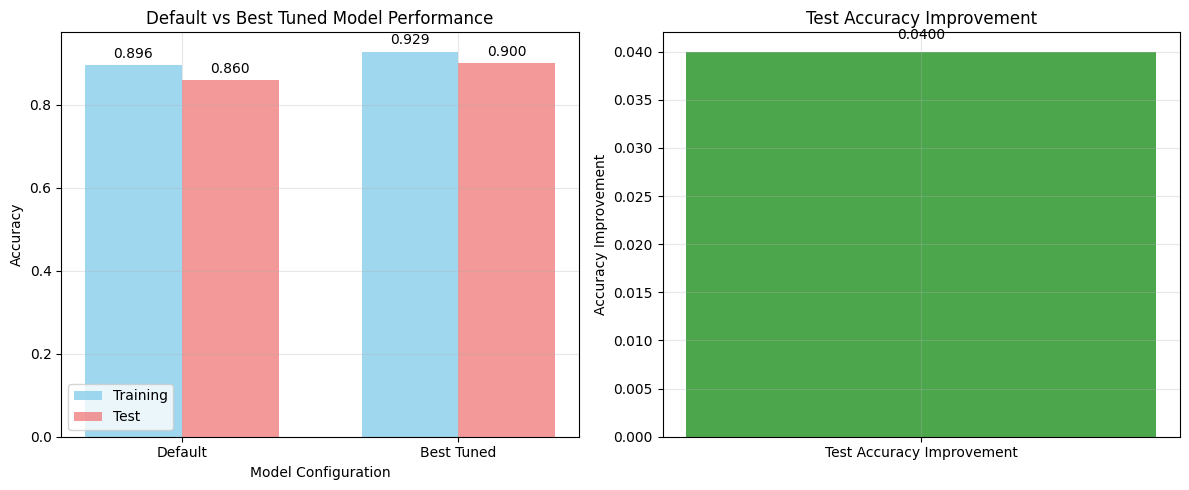

In [6]:
# Analyze results and find best performing model
results_df = pd.DataFrame(results)

# Find best model (highest test accuracy)
best_idx = results_df['test_acc'].idxmax()
best_params = results_df.iloc[best_idx]

print("=== All Hyperparameter Tuning Results ===")
print(results_df.sort_values(['penalty', 'C']).reset_index(drop=True))

print(f"\n=== Best Model Configuration ===")
print(f"penalty: {best_params['penalty']}")
print(f"C: {best_params['C']}")
print(f"Training accuracy: {best_params['train_acc']:.4f}")
print(f"Test accuracy: {best_params['test_acc']:.4f}")

# Create comparison table
comparison_data = {
    'Model': ['Default Settings', 'Best Tuned Model'],
    'penalty': ['l2', best_params['penalty']],
    'C': [1.0, best_params['C']],
    'Train Accuracy': [baseline_train_acc, best_params['train_acc']],
    'Test Accuracy': [baseline_test_acc, best_params['test_acc']],
    'Improvement': ['-', f"{best_params['test_acc'] - baseline_test_acc:.4f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print(f"\n=== Default vs Best Tuned Model Comparison ===")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart comparison
models = ['Default', 'Best Tuned']
train_accs = [baseline_train_acc, best_params['train_acc']]
test_accs = [baseline_test_acc, best_params['test_acc']]

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, train_accs, width, label='Training', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, test_accs, width, label='Test', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Model Configuration')
ax1.set_ylabel('Accuracy')
ax1.set_title('Default vs Best Tuned Model Performance')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (train, test) in enumerate(zip(train_accs, test_accs)):
    ax1.text(i - width/2, train + 0.01, f'{train:.3f}', ha='center', va='bottom')
    ax1.text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', va='bottom')

# Line plot showing improvement
improvement = best_params['test_acc'] - baseline_test_acc
ax2.bar(['Test Accuracy Improvement'], [improvement], color='green', alpha=0.7)
ax2.set_ylabel('Accuracy Improvement')
ax2.set_title('Test Accuracy Improvement')
ax2.grid(True, alpha=0.3)

# Add value label
ax2.text(0, improvement + 0.001, f'{improvement:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Results saved to 'logreg_results.csv'


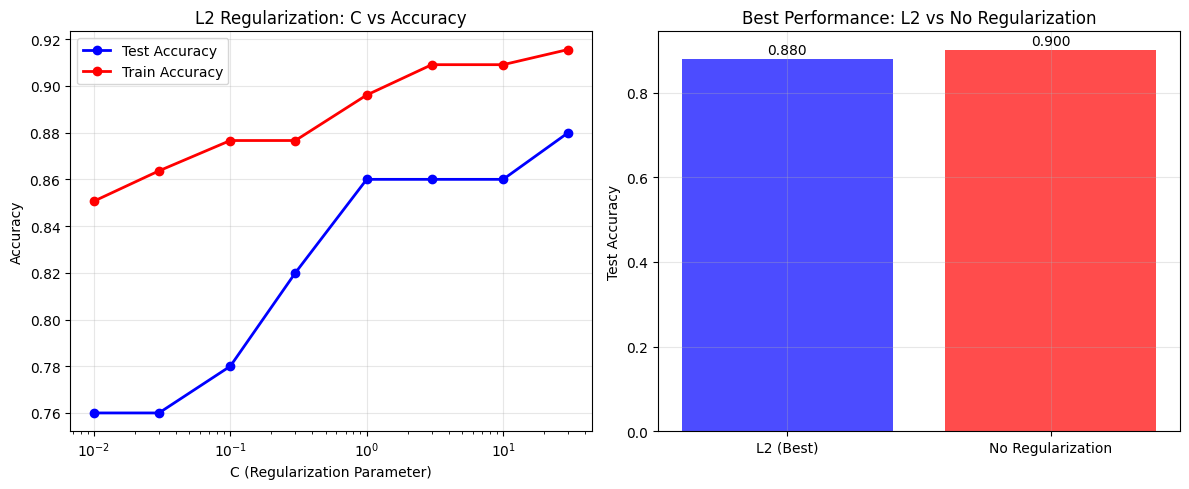

Hyperparameter analysis plot saved as 'logreg_hyperparameter_analysis.png'


In [7]:
# Save results to CSV
results_df.to_csv('logreg_results.csv', index=False)
print("Results saved to 'logreg_results.csv'")

# Create hyperparameter tuning visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 1. C vs Test Accuracy for L2 Regularization
l2_results = results_df[results_df['penalty'] == 'l2']
ax1.plot(l2_results['C'], l2_results['test_acc'], 'bo-', label='Test Accuracy', linewidth=2, markersize=6)
ax1.plot(l2_results['C'], l2_results['train_acc'], 'ro-', label='Train Accuracy', linewidth=2, markersize=6)
ax1.set_xscale('log')
ax1.set_xlabel('C (Regularization Parameter)')
ax1.set_ylabel('Accuracy')
ax1.set_title('L2 Regularization: C vs Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Comparison: L2 vs No Regularization
none_results = results_df[results_df['penalty'] == 'none']
ax2.bar(['L2 (Best)', 'No Regularization'], 
        [l2_results['test_acc'].max(), none_results['test_acc'].iloc[0]], 
        color=['blue', 'red'], alpha=0.7)
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Best Performance: L2 vs No Regularization')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate([l2_results['test_acc'].max(), none_results['test_acc'].iloc[0]]):
    ax2.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('logreg_hyperparameter_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Hyperparameter analysis plot saved as 'logreg_hyperparameter_analysis.png'")
